<a href="https://colab.research.google.com/github/jwells52/creating-ai-enabled-systems/blob/main/FSL_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install EasyFSL

In [ ]:
!pip install easyfsl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 5.7 MB/s eta 0:00:00


### Download Humpback Whale Identification dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir /root/.kaggle && cp /content/drive/MyDrive/kaggle.json /root/.kaggle/kaggle.json && chmod 600 /root/.kaggle/kaggle.json && kaggle competitions download -c humpback-whale-identification
!unzip humpback-whale-identification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/cd2c4ae6b.jpg     
  inflating: train/cd310f07c.jpg     
  inflating: train/cd32697ae.jpg     
  inflating: train/cd346388a.jpg     
  inflating: train/cd36f1901.jpg     
  inflating: train/cd382b662.jpg     
  inflating: train/cd3937f27.jpg     
  inflating: train/cd3a073a2.jpg     
  inflating: train/cd3afe416.jpg     
  inflating: train/cd407fae0.jpg     
  inflating: train/cd437a15c.jpg     
  inflating: train/cd444321e.jpg     
  inflating: train/cd4740ee9.jpg     
  inflating: train/cd49e7801.jpg     
  inflating: train/cd4b8f33f.jpg     
  inflating: train/cd4fae084.jpg     
  inflating: train/cd520d861.jpg     
  inflating: train/cd52c565c.jpg     
  inflating: train/cd5577b32.jpg     
  inflating: train/cd5712905.jpg     
  inflating: train/cd598b557.jpg     
  inflating: train/cd59d5874.jpg     
  inflating: train/cd5a9c5b1.jpg     
  inflating: train/cd5b23ddc.jpg     
  inflating: train/cd5dd712e.jpg     

### Imports

In [ ]:
import os
import torch
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from easyfsl.datasets import FewShotDataset
from easyfsl.modules import resnet12
from easyfsl.methods import PrototypicalNetworks, FewShotClassifier
from easyfsl.utils import evaluate
from easyfsl.samplers import TaskSampler

from torch import Tensor, nn
from torch.optim import SGD, Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from typing import List, Optional, Tuple, Callable
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
class HumpbackWhaleDataset(FewShotDataset):
  def __init__(self, image_dir: str, labels: pd.DataFrame, transform=None):
    self.image_dir = image_dir
    self.labels = labels
    self.transform = transform
    self.label_to_id = {label:i for i, label in enumerate(self.labels['Id'].unique())}
    self.id_to_label = {i:label for label, i in self.label_to_id.items()}

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx: int):
    item = self.labels.iloc[idx]
    image_name, label = item['Image'], self.label_to_id[item['Id']]

    image_path = os.path.join(self.image_dir, image_name)
    image = Image.open(image_path)

    if self.transform is not None:
      image = self.transform(image)

    return image, label

  def get_labels(self):
    return self.labels['Id'].values


### Load dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/new_train.csv')

# Remove new_whale class
df = df[df['Id'] != 'new_whale']

In [ ]:
# def class_count(df, label):
#   return len(df[df['Id'] == label])

# df['class_count'] = df['Id'].apply(lambda label: class_count(df, label))

In [ ]:
# Filter out classes that have less than 5 samples
# This is so we can easily implement Few Shot Learning for initial experiments

nshot_df = df[df['class_count'] > 10]
nshot_df.sample(frac=1).reset_index(drop=True, inplace=True) # Shuffle data

In [ ]:
print(f"Min # of samples for a class after filtering = {nshot_df['class_count'].min()}")
print(f"Max # of samples for a class after filtering = {nshot_df['class_count'].max()}")
print(f"# of classes after filtering = {len(nshot_df['Id'].unique())}")


Min # of samples for a class after filtering = 11
Max # of samples for a class after filtering = 73
# of classes after filtering = 227


### Define few shot learning network

In [ ]:
cnn = resnet12()
few_shot_classifier = PrototypicalNetworks(cnn).to(device)

### Set up training

In [ ]:
# Number of Training Task for each epoch
# A training task is a random sample of N shots (images) for M classes
n_task_per_epoch = 100

# Number of Validation tasks for evaluation during training
n_validation_task = 20

In [ ]:
train_set = HumpbackWhaleDataset(
    image_dir='/content/train',
    labels=nshot_df,
    transform=transforms.Compose(
      [
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((256, 512)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
      ])
)

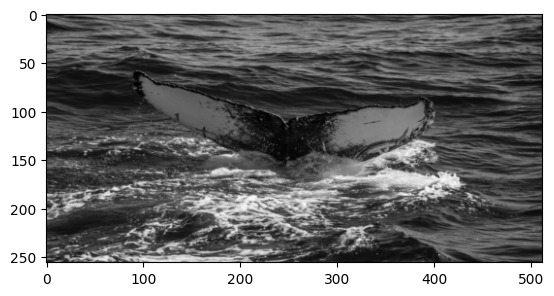

In [ ]:
plt.imshow(next(iter(train_set))[0].permute(1, 2, 0).numpy())

In [ ]:
train_sampler = TaskSampler(
    train_set, n_way=5, n_shot=5, n_query=5, n_tasks=n_task_per_epoch
)

In [ ]:
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn
)

In [ ]:
n_epochs = 50
learning_rate = 1e-2

loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
# optimizer = Adam(few_shot_classifier.parameters(), lr=learning_rate)
optimizer = SGD(few_shot_classifier.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

### Training functions

In [ ]:
def training_epoch(
    model: FewShotClassifier,
    data_loader: DataLoader,
    optimizer: Optimizer,
    loss_fn: Callable
):
    all_loss = []
    model.train()
    with tqdm(
        enumerate(data_loader), total=len(data_loader), desc="Training"
    ) as tqdm_train:
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            _,
        ) in tqdm_train:
            optimizer.zero_grad()
            model.process_support_set(
                support_images.to(device), support_labels.to(device)
            )
            classification_scores = model(query_images.to(device))

            loss = loss_fn(classification_scores, query_labels.to(device))
            loss.backward()
            optimizer.step()

            all_loss += [loss.item()]

            tqdm_train.set_postfix(loss=np.mean(all_loss))

    return np.mean(all_loss)

### Train network

In [ ]:
# best_state = fs_clf.state_dict()
# best_validation_accuracy = 0.0

train_losses = []
for epoch in range(n_epochs):
    print(f"\nEpoch {epoch}")
    epoch_loss = training_epoch(few_shot_classifier, train_loader, optimizer, loss_fn)
    train_losses += [epoch_loss]

    # validation_accuracy = evaluate(
    #     fs_clf, valid_loader, device=device, tqdm_prefix="Validation"
    # )


    # if validation_accuracy > best_validation_accuracy:
    #     best_validation_accuracy = validation_accuracy
    #     best_state = fs_clf.state_dict()
    #     print("Ding ding ding! We found a new best model!")

    # tb_writer.add_scalar("Train/loss", average_loss, epoch)
    # tb_writer.add_scalar("Val/acc", validation_accuracy, epoch)

    optimizer.step()


Epoch 0


Training: 100%|██████████| 100/100 [00:57<00:00,  1.73it/s, loss=1.55]


Epoch 1



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=1.41]


Epoch 2



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=1.32]


Epoch 3



Training: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s, loss=1.23]


Epoch 4



Training: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s, loss=1.2]


Epoch 5



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=1.22]


Epoch 6



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=1.12]


Epoch 7



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=1.1]


Epoch 8



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=1.05]


Epoch 9



Training: 100%|██████████| 100/100 [00:48<00:00,  2.04it/s, loss=1.06]


Epoch 10



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=1.04]


Epoch 11



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=0.961]


Epoch 12



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=1.01]


Epoch 13



Training: 100%|██████████| 100/100 [00:49<00:00,  2.04it/s, loss=0.977]


Epoch 14



Training: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s, loss=0.96]


Epoch 15



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=0.878]


Epoch 16



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=0.856]


Epoch 17



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=0.837]


Epoch 18



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=0.802]


Epoch 19



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=0.796]


Epoch 20



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=0.778]


Epoch 21



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=0.752]


Epoch 22



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=0.698]


Epoch 23



Training: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s, loss=0.706]


Epoch 24



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=0.667]


Epoch 25



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=0.696]


Epoch 26



Training: 100%|██████████| 100/100 [00:48<00:00,  2.04it/s, loss=0.689]


Epoch 27



Training: 100%|██████████| 100/100 [00:48<00:00,  2.04it/s, loss=0.695]


Epoch 28



Training: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s, loss=0.661]


Epoch 29



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=0.627]


Epoch 30



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=0.647]


Epoch 31



Training: 100%|██████████| 100/100 [00:48<00:00,  2.04it/s, loss=0.615]


Epoch 32



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=0.608]


Epoch 33



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=0.597]


Epoch 34



Training: 100%|██████████| 100/100 [00:49<00:00,  2.04it/s, loss=0.6]


Epoch 35



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=0.587]


Epoch 36



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=0.567]


Epoch 37



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=0.555]


Epoch 38



Training: 100%|██████████| 100/100 [00:48<00:00,  2.04it/s, loss=0.554]


Epoch 39



Training: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s, loss=0.559]


Epoch 40



Training: 100%|██████████| 100/100 [00:48<00:00,  2.04it/s, loss=0.523]


Epoch 41



Training: 100%|██████████| 100/100 [00:48<00:00,  2.04it/s, loss=0.565]


Epoch 42



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=0.52]


Epoch 43



Training: 100%|██████████| 100/100 [00:48<00:00,  2.04it/s, loss=0.512]


Epoch 44



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=0.558]


Epoch 45



Training: 100%|██████████| 100/100 [00:48<00:00,  2.04it/s, loss=0.483]


Epoch 46



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=0.498]


Epoch 47



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=0.444]


Epoch 48



Training: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=0.466]


Epoch 49



Training: 100%|██████████| 100/100 [00:49<00:00,  2.04it/s, loss=0.455]


In [ ]:
torch.save(few_shot_classifier.state_dict, '/content/drive/MyDrive/prototypical_network_v1')

In [ ]:
accuracies = []
few_shot_classifier.eval()
for batch in train_loader:
    optimizer.zero_grad()
    few_shot_classifier.process_support_set(
        support_images.to(device), support_labels.to(device)
    )
    classification_scores = model(query_images.to(device))

    loss = loss_fn(classification_scores, query_labels.to(device))

tensor([[[[0.4667, 0.4667, 0.4824,  ..., 0.3843, 0.3922, 0.3804],
          [0.4510, 0.4510, 0.4588,  ..., 0.4157, 0.4118, 0.4157],
          [0.4157, 0.4235, 0.4275,  ..., 0.4392, 0.4431, 0.4471],
          ...,
          [0.5294, 0.5294, 0.5333,  ..., 0.3451, 0.3490, 0.3490],
          [0.5725, 0.5725, 0.5686,  ..., 0.3216, 0.3333, 0.3333],
          [0.5961, 0.6000, 0.5961,  ..., 0.3412, 0.3490, 0.3529]],

         [[0.4667, 0.4667, 0.4824,  ..., 0.3843, 0.3922, 0.3804],
          [0.4510, 0.4510, 0.4588,  ..., 0.4157, 0.4118, 0.4157],
          [0.4157, 0.4235, 0.4275,  ..., 0.4392, 0.4431, 0.4471],
          ...,
          [0.5294, 0.5294, 0.5333,  ..., 0.3451, 0.3490, 0.3490],
          [0.5725, 0.5725, 0.5686,  ..., 0.3216, 0.3333, 0.3333],
          [0.5961, 0.6000, 0.5961,  ..., 0.3412, 0.3490, 0.3529]],

         [[0.4667, 0.4667, 0.4824,  ..., 0.3843, 0.3922, 0.3804],
          [0.4510, 0.4510, 0.4588,  ..., 0.4157, 0.4118, 0.4157],
          [0.4157, 0.4235, 0.4275,  ..., 0